<a id='start'></a>
# Esercizi Serie storiche

In questo notebook vengono presentati degli esercizi sulle serie storiche (_time series_).

Provate a svolgere il seguente esercizio:<br>
1) [Analisi di una time series](#section1)<br>
2) [Scomposizione nelle componenti principali](#section2)<br>
3) [Eliminazione di trend e stagionalità](#section3)<br>
4) [Predizione sulla serie originale](#section4)<br>

<a id='section1'></a>
## Analisi di una time series

Analizziamo i dati dei passeggeri dei voli di linea negli Stati Uniti:

In [1]:
import pandas as pd

df = pd.read_csv('data/AirPassengers.csv', parse_dates=['date'], index_col='date')
df

,value
date,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121
...,...
1960-08-01,606
1960-09-01,508
1960-10-01,461


In [2]:
df.index

DatetimeIndex(['1949-01-01', '1949-02-01', '1949-03-01', '1949-04-01',
               '1949-05-01', '1949-06-01', '1949-07-01', '1949-08-01',
               '1949-09-01', '1949-10-01',
               ...
               '1960-03-01', '1960-04-01', '1960-05-01', '1960-06-01',
               '1960-07-01', '1960-08-01', '1960-09-01', '1960-10-01',
               '1960-11-01', '1960-12-01'],
              dtype='datetime64[ns]', name='date', length=144, freq=None)

Effettuiamo la visualizzazione dei dati con un grafico a linee (sia normale che con two sided view):

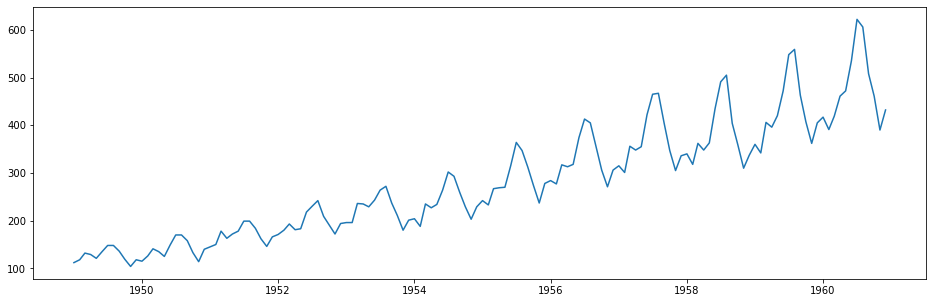

In [2]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16,5))
plt.plot(df.index, df.value)
plt.show()


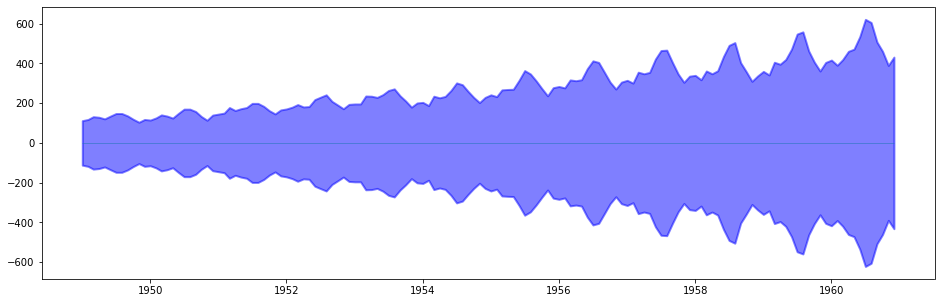

In [3]:
import numpy as np

plt.figure(figsize=(16,5))
plt.fill_between(df.index, y1=df.value, y2=-df.value, alpha=0.5, linewidth=2, color='blue')
plt.hlines(y=0, xmin=np.min(df.index), xmax=np.max(df.index), linewidth=.5)
plt.show()

Analizziamo l'autocorrelazione di questa serie:

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
/opt/anaconda3/envs/jupyter/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


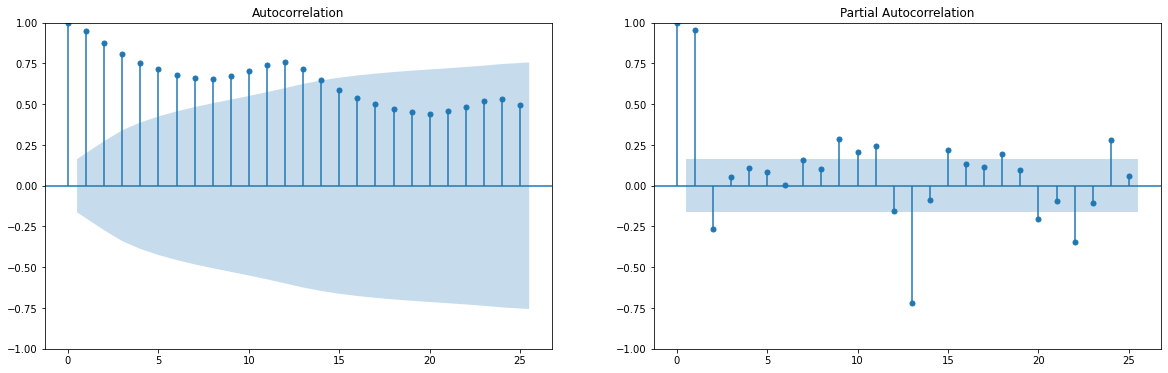

In [4]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, axes = plt.subplots(1, 2, figsize=(20,6))
plot_acf(df.value.tolist(), lags=25, ax=axes[0])
plot_pacf(df.value.tolist(), lags=25, ax=axes[1])
plt.show()

I dati presentati in questa serie mostrano una certa autocorrelazione ed è possibile vedere che i dati hanno una stagionalità circa annuale (come era facile prevedere).

Proseguiamo quindi con un'analisi di stazionarietà:

In [5]:
from statsmodels.tsa.stattools import adfuller

X = df.values
result = adfuller(X)

print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')

for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: 0.815369
p-value: 0.991880
Critical Values:
	1%: -3.482
	5%: -2.884
	10%: -2.579


Dal valore di questa statistica sembra che la serie non sia stazionaria ma abbia un trend o una stagionalità (in realtà possiamo immaginare le abbia entrambe). La serie è molto più probabilmente stazionaria quanto più il valore del Augmented Dickey-Fuller test (ADF) è negativo.

<a id='section2'></a>
## Scomposizione nelle componenti principali

Eseguiamo le tecniche viste per realizzare una scomposizione nelle componenti principali dei dati di questa serie storica:

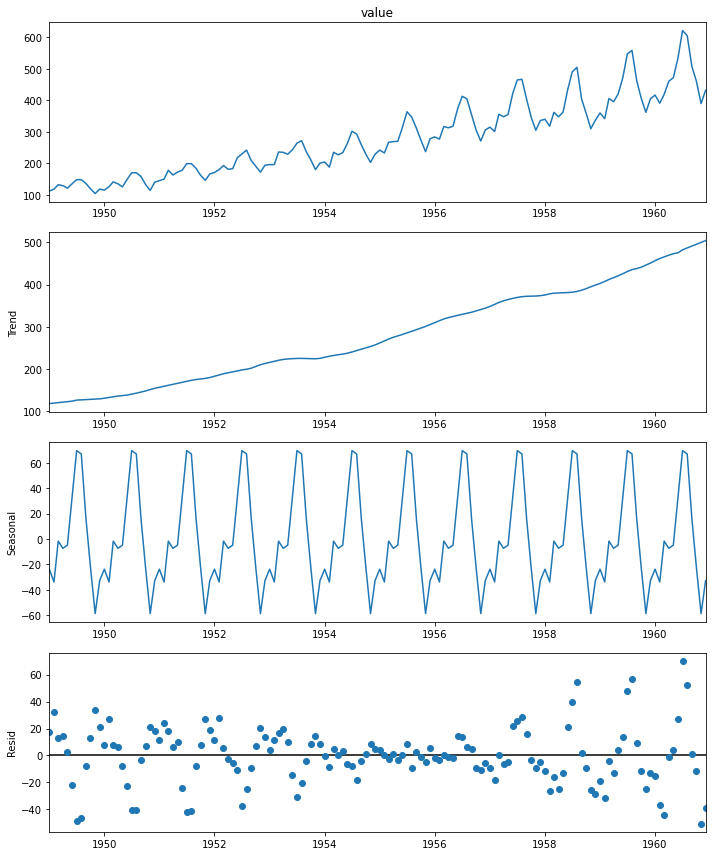

In [6]:
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse

# Multiplicative Decomposition 
result_add = seasonal_decompose(df['value'], model='additive', extrapolate_trend='freq')

# Plot
plt.rcParams.update({'figure.figsize': (10, 12)})
result_add.plot()
plt.show()

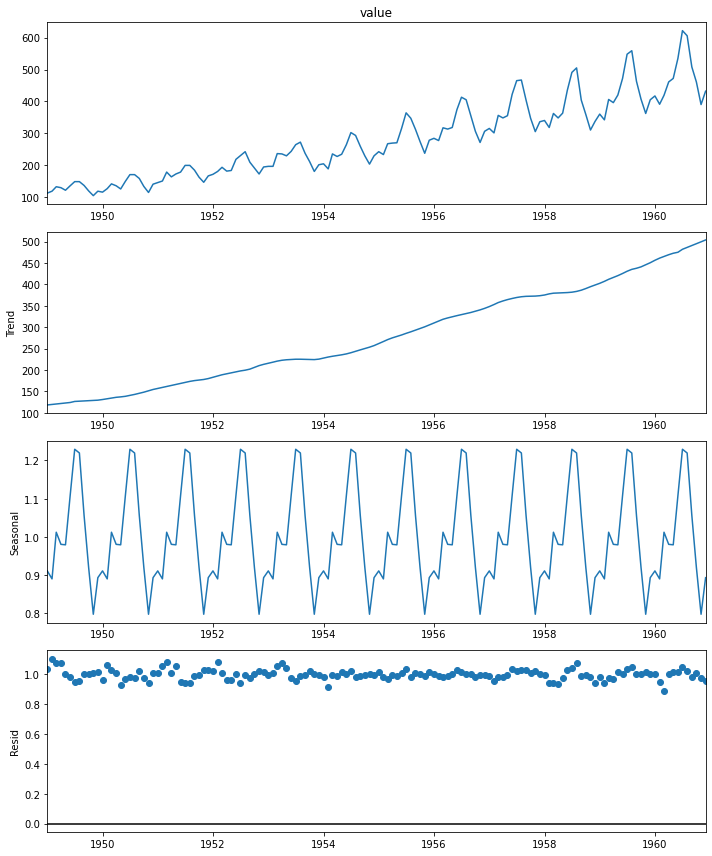

In [7]:
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse

# Multiplicative Decomposition 
result_add = seasonal_decompose(df['value'], model='multiplicative', extrapolate_trend='freq')

# Plot
plt.rcParams.update({'figure.figsize': (10, 12)})
result_add.plot()
plt.show()

<a id='section3'></a>
## Eliminazione di trend e stagionalità

Eliminiamo il trend:

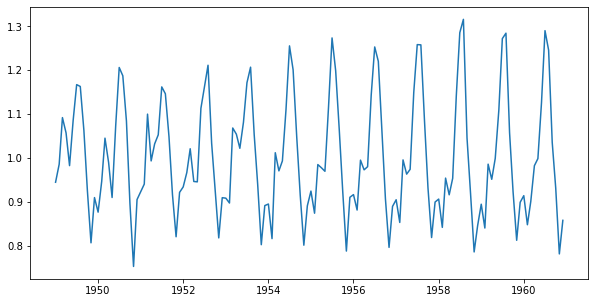

In [8]:
from scipy import signal
from statsmodels.tsa.seasonal import seasonal_decompose

result_mul = seasonal_decompose(df['value'], model='multiplicative', extrapolate_trend='freq')
detrended = df.value.values / result_mul.trend

plt.rcParams.update({'figure.figsize': (10, 5)})
plt.plot(df.index, detrended)
plt.show()

Eliminiamo la stagionalità:

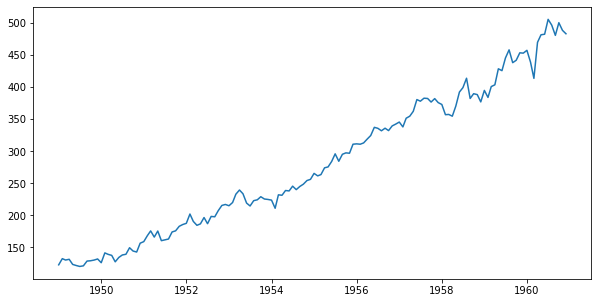

In [9]:
from scipy import signal
from statsmodels.tsa.seasonal import seasonal_decompose

result_mul = seasonal_decompose(df['value'], model='multiplicative', extrapolate_trend='freq')
deseasonalized = df.value.values / result_mul.seasonal

plt.rcParams.update({'figure.figsize': (10, 5)})
plt.plot(df.index, deseasonalized)
plt.show()

Eliminiamo sia trand che stagionalità:

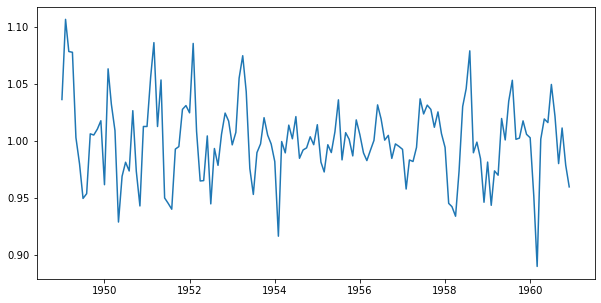

In [10]:
from scipy import signal
from statsmodels.tsa.seasonal import seasonal_decompose

result_mul = seasonal_decompose(df['value'], model='multiplicative', extrapolate_trend='freq')
deseasoned = df.value.values / result_mul.seasonal
deseasoned_detrended = deseasoned / result_mul.trend

plt.rcParams.update({'figure.figsize': (10, 5)})
plt.plot(df.index, deseasoned_detrended)
plt.show()

Proviamo a fare un'analisi di stazionarietà sulla serie così ottenuta:

In [11]:
new_df = df.copy()
new_df['value'] = deseasoned_detrended

from statsmodels.tsa.stattools import adfuller

result = adfuller(new_df.values)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')

for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -7.590191
p-value: 0.000000
Critical Values:
	1%: -3.479
	5%: -2.883
	10%: -2.578


I risultati di questa statistica ci dicono che la sere ottenuta è stazionaria con livello di significatività inferiore all'1%.

<a id='section4'></a>
## Predizione della serie originale

Proviamo a provedere i prossimi 3 anni (36 mesi) dei dati di questa serie:

In [12]:
import pmdarima as pm

smodel = pm.auto_arima(df, start_p=1, start_q=1,
                       test='adf',
                       max_p=3, max_q=3, m=12,
                       start_P=0, seasonal=True,
                       d=None, D=1, trace=True,
                       error_action='ignore',  
                       suppress_warnings=True, 
                       stepwise=True)

smodel.summary()

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=1022.896, Time=0.20 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1031.508, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1020.393, Time=0.10 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1021.003, Time=0.13 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=1020.393, Time=0.03 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=1019.239, Time=0.26 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=1.86 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=1020.493, Time=0.29 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=1032.120, Time=0.18 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=1021.120, Time=0.39 sec
 ARIMA(1,1,1)(2,1,0)[12]             : AIC=1021.032, Time=0.47 sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC=1019.178, Time=0.33 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=1020.425, Time=0.10 sec
 ARIMA(0,1,1)(2,1,1)[12]             : AIC=inf, Time=2.18 sec
 ARIMA(0,1,1)(1,1,1)[12]     

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  144
Model:             SARIMAX(0, 1, 1)x(2, 1, [], 12)   Log Likelihood                -505.589
Date:                             Wed, 30 Mar 2022   AIC                           1019.178
Time:                                     11:05:49   BIC                           1030.679
Sample:                                          0   HQIC                          1023.851
                                             - 144                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3634      0.074     -4.945      0.000      -0.508      -0.219
ar.S.L12      -0.1239      0.090     -1.372      0.170      -0.301       0.053
ar.S.L24       0.1911      0.107      1.783      0.075      -0.019       0.401
sigma2       130.4480     15.527      8.402      0.000     100.016     160.880
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 4.59
Prob(Q):                              0.92   Prob(JB):                         0.10
Heteroskedasticity (H):               2.70   Skew:                             0.15
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.87
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

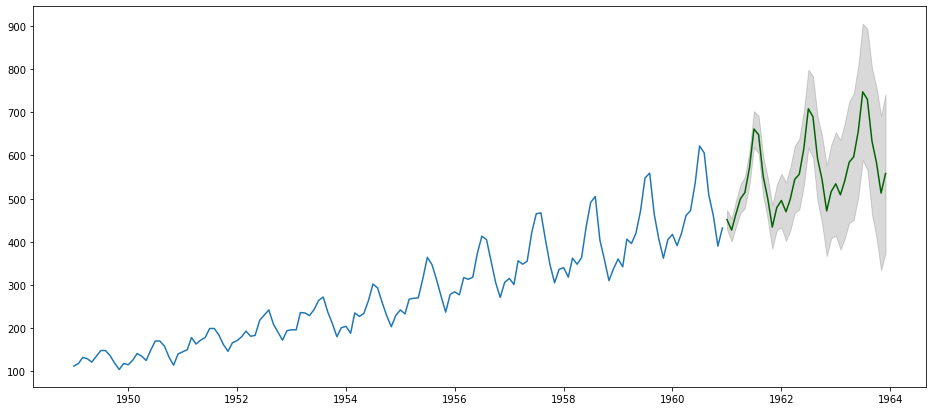

In [15]:
# Forecast
n_periods = 36
fitted, confint = smodel.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = pd.date_range(df.index[-1], periods=n_periods+1, freq='MS')[1:]

# make series for plotting purpose
fitted_series = pd.Series(fitted, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.figure(figsize=(16, 7))
plt.plot(df)
plt.plot(fitted_series, color='darkgreen')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)
plt.show()

Proviamo a fare lo stesso, usando Prophet:

In [18]:
from fbprophet import Prophet
import matplotlib.pyplot as plt

df_p = df.reset_index().rename(columns={'date': 'ds', 'value': 'y'})
model = Prophet(seasonality_mode='multiplicative', weekly_seasonality=True, daily_seasonality=True)
model.fit(df_p)

/opt/anaconda3/envs/jupyter/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -2.46502


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       507.106    0.00326126       157.317      0.5252      0.5252      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        517.28    0.00492246       693.734           1           1      247   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       522.983    0.00177631       170.039           1           1      371   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       525.772    0.00263052       137.515       1.459      0.1459      499   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     406           526   0.000223071       372.508   2.309e-06       0.001      553  LS failed, Hessian reset 
     499       527.856    0.00597253       259.584      0.9981      0.9981      6

/opt/anaconda3/envs/jupyter/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/anaconda3/envs/jupyter/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


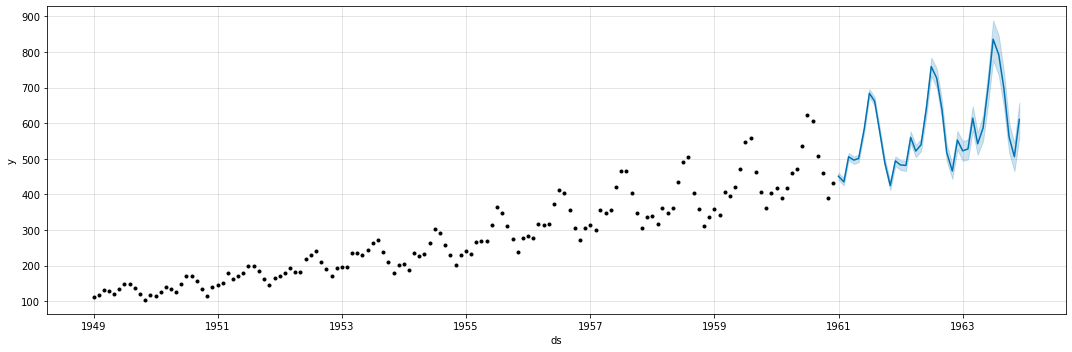

In [19]:
future = pd.DataFrame()
future['ds'] = pd.date_range(start=df.index.max(), periods=n_periods, freq="BM")
df_fcst = model.predict(df=future)

f, ax = plt.subplots(1, 1, figsize=(15, 5))
fig = model.plot(df_fcst, ax=ax)
plt.show()

/opt/anaconda3/envs/jupyter/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/anaconda3/envs/jupyter/lib/python3.9/site-packages/fbprophet/plot.py:422: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(yticklabels)
/opt/anaconda3/envs/jupyter/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/anaconda3/envs/jupyter/lib/python3.9/site-packages/fbprophet/plot.py:422: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(yticklabels)
/opt/anaconda3/envs/jupyter/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: Th

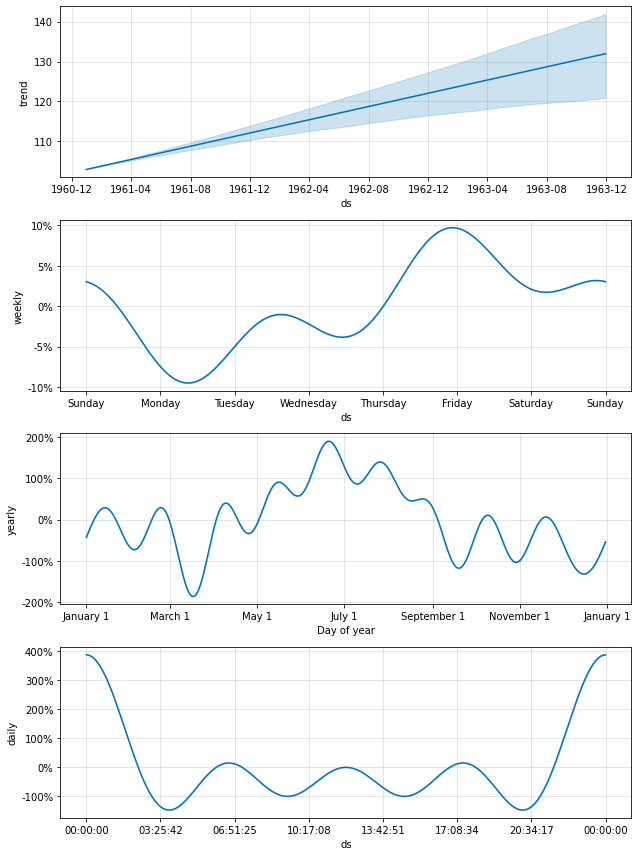

In [20]:
fig = model.plot_components(df_fcst)

[Clicca qui per tornare all'inizio della pagina](#start)<a id='start'></a>